# Bayesian Optimization

Mandana Goudarzi 

2122279

In many real-world scenarios, evaluating an objective function can be computationally expensive, time-consuming, or resource-intensive. Examples include hyperparameter tuning in machine learning models, engineering design optimization, and experimental sciences. To address this challenge, Bayesian optimization provides an efficient framework for optimizing such expensive functions by constructing a surrogate model. This notebook demonstrates how to use Gaussian Process (GP) regression, a powerful surrogate modeling technique, to approximate a one-dimensional function and guide the optimization process.

### Methodology

1. **Function Selection and Sampling**:
   - We will choose a one-dimensional function ( f(x) = xsin(x) ), and sample a few random points from it.
   
2. **Gaussian Process Regression**:
   - Using the sampled points, we will fit a Gaussian Process model. The GP model provides a probabilistic approach to regression, offering both mean and variance predictions for new points.
   - We will use the Gaussian Process formulas to compute the mean and variance at each point.

3. **Kernel Function**:
   - The kernel function is a critical component of the GP model. It determines the covariance structure of the process. In this notebook, we will use the RBF kernel function and explore the effect of different kernel parameters on the GP model.

4. **Acquisition Function**:
   - The acquisition function will be used to guide the selection of new points to sample, balancing exploration and exploitation.

5. **Visualization**:
   - We will plot the GP mean and variance to visualize the approximation and the uncertainty in predictions.


In [68]:
import numpy as np
from scipy.stats import norm
from numpy.random import normal
from numpy.random import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import seaborn as sns
from scipy.optimize import minimize
from PIL import Image
import io
from IPython.display import Image


## Objective Function
Let's define the objective function and sample a few points with added noise.

In [51]:
# Set random seed for reproducibility
np.random.seed(42)

# Define objective function 
def objective_function(x):
    return x * np.sin(x)

# Sample a few random points from the function and add noise
X_sample = np.sort(np.random.uniform(0, 10, 6)).reshape(-1, 1)
Y_sample = objective_function(X_sample) + np.random.normal(0, 0.5, X_sample.shape)

X = np.linspace(0, 10, 1000).reshape(-1, 1)
Y = objective_function(X)

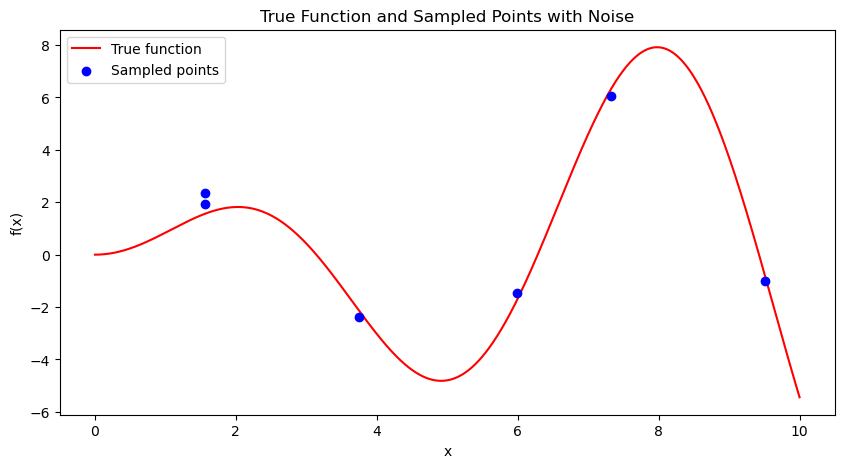

In [52]:
# Plot the true function and sampled points
plt.figure(figsize=(10, 5))
plt.plot(X, Y, 'r-', label='True function')
plt.scatter(X_sample, Y_sample, color='blue', label='Sampled points', zorder=5)
plt.title('True Function and Sampled Points with Noise')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()


## Gaussian Process Regression

Then we implement Gaussian Process (GP) regression, a non-parametric method used to predict values and quantify uncertainty in predictions.

### 1. Radial Basis Function (RBF) Kernel

First, we define the RBF kernel function, which is used to measure the similarity between data points. The kernel function is given by:

$$ k(a, b) = \text{variance} \times \exp\left(-\frac{1}{2 \times \text{length\_scale}^2} \text{sqdist}(a, b)\right) $$

where `sqdist(a, b)` is the squared distance between points `a` and `b`, calculated as:

$$ \text{sqdist}(a, b) = \sum_{i} a_i^2 + \sum_{j} b_j^2 - 2 \cdot \text{dot}(a, b^T) $$

### 2. Compute Covariance Matrix

We compute the covariance matrix \( K \) for the sample points using the defined kernel function. The covariance matrix \( K \) incorporates a noise variance term to account for measurement noise:



In [53]:
# Define the RBF kernel function
def kernel(a, b, length_scale, variance):
    sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2 * np.dot(a, b.T)
    return variance * np.exp(-0.5 / length_scale**2 * sqdist)

# Compute the covariance matrix K
length_scale = 1.3
variance = 2.96 * 10
noise_variance = 0.5**2
K = kernel(X_sample, X_sample, length_scale, variance) + noise_variance * np.eye(len(X_sample))
K_inv = np.linalg.inv(K)

# Make predictions for new points given the observed data
def gp_predict(X_new, X_sample, Y_sample, K, length_scale, variance):
    # Covarience between the sample points and the new points
    K_s = kernel(X_sample, X_new, length_scale, variance)
    # Covarience between new points
    K_ss = kernel(X_new, X_new, length_scale, variance)
    
    # Mean prediction
    mu_s = K_s.T.dot(K_inv).dot(Y_sample)
    
    # Covariance prediction
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, np.sqrt(np.diag(cov_s))

# Generate predictions over a range of x values
X = np.linspace(0, 10, 1000).reshape(-1, 1)
# Computees the mean and standard deviation for the predictions
Y_pred, sigma = gp_predict(X, X_sample, Y_sample, K, length_scale, variance)

sigma = sigma.reshape(-1)


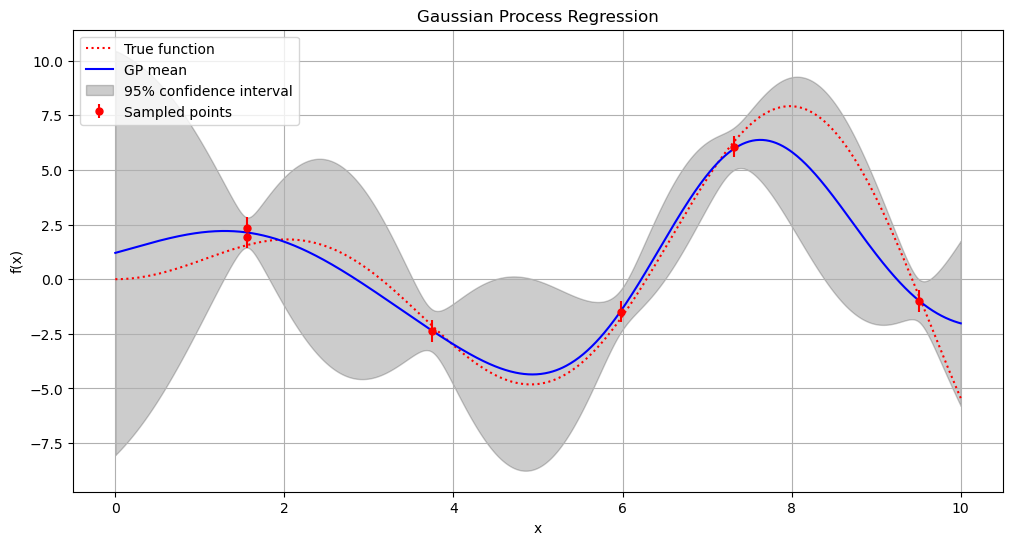

In [54]:
# Plot the true function, sampled points, GP predictions
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(X, objective_function(X), 'r:', label='True function')
ax1.errorbar(X_sample, Y_sample.ravel(), yerr=0.5, fmt='r.', markersize=10, label='Sampled points')
ax1.plot(X, Y_pred, 'b-', label='GP mean')
ax1.fill_between(X.ravel(), Y_pred.ravel() - 1.96 * sigma, Y_pred.ravel() + 1.96 * sigma, alpha=0.2, color='k', label='95% confidence interval')
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.legend(loc='upper left')
ax1.grid(True)

plt.title('Gaussian Process Regression')
plt.show()


## Upper Confidence Bound (UCB) Acquisition Function and Sequential Sampling

In this section, we implement the Upper Confidence Bound (UCB) acquisition function to sequentially select new sampling points for our Gaussian Process (GP) regression model.

### 3. Upper Confidence Bound (UCB) Acquisition Function

The UCB acquisition function is defined as:

$$ \alpha_{\text{UCB}}(x) = \mu(x) + \beta \cdot \sigma(x) $$

where:
- \( \ mu(x) \) is the mean prediction at point \( x \). 
- \( \sigma(x) \) is the standard deviation (uncertainty) at point \( x \).
- \( \beta \) is a parameter that controls the exploration-exploitation trade-off.

The UCB acquisition function encourages exploration by adding a multiple of the uncertainty to the mean prediction.


In [55]:
# Upper Confidence Bound acquisition function
def ucb(x, X_sample, Y_sample, K_inv, length_scale, variance, beta=3.0):
    x = x.reshape(-1, 1)
    mu, sigma = gp_predict(x, X_sample, Y_sample, K_inv, length_scale, variance)
    return mu + beta * sigma

# Sequentially pick the next n_points points using UCB
n_points = 20
X_next = []
acquisition_values = []

for _ in range(n_points):
    # Optimize the acquisition function to find the next sampling point
    res = minimize(lambda x: -ucb(x, X_sample, Y_sample, K_inv, length_scale, variance),
                   x0=np.random.uniform(0, 10),
                   bounds=((0, 10),))
    
    x_next = res.x
    X_next.append(x_next)
    
    # Augment the sample points
    X_sample = np.vstack((X_sample, x_next))
    Y_sample = np.vstack((Y_sample, objective_function(x_next) + np.random.normal(0, 0.5, (1, 1))))
    
    # Update the covariance matrix and its inverse
    K = kernel(X_sample, X_sample, length_scale, variance) + noise_variance * np.eye(len(X_sample))
    K_inv = np.linalg.inv(K)

    # Store acquisition function values
    acquisition_values.append(ucb(X, X_sample, Y_sample, K_inv, length_scale, variance))


Y_pred, sigma = gp_predict(X, X_sample, Y_sample, K_inv, length_scale, variance)

sigma = sigma.reshape(-1)

# Generate acquisition values
acquisition_values = ucb(X, X_sample, Y_sample, K_inv, length_scale, variance)

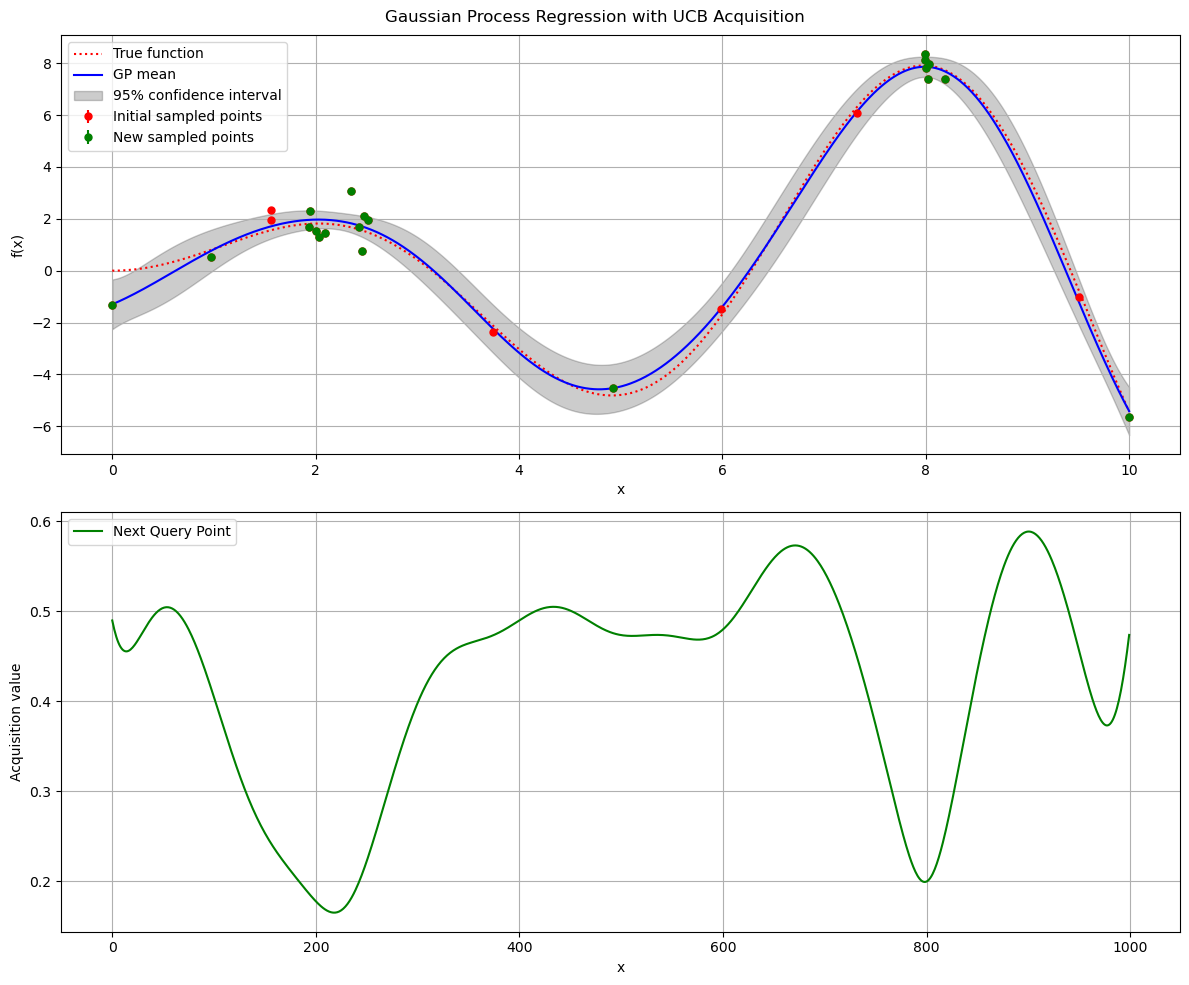

In [58]:
# Plot the true function, sampled points, GP predictions, and the acquisition function
fig, (ax1 , ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the true function and sampled points
ax1.plot(X, objective_function(X), 'r:', label='True function')
ax1.errorbar(X_sample, Y_sample.ravel(), yerr=0, fmt='r.', markersize=10, label='Initial sampled points')
ax1.errorbar(X_sample[-n_points:], Y_sample[-n_points:].ravel(), yerr=0, fmt='g.', markersize=10, label='New sampled points')
ax1.plot(X, Y_pred, 'b-', label='GP mean')
ax1.fill_between(X.ravel(), Y_pred.ravel() - 1.96 * sigma, Y_pred.ravel() + 1.96 * sigma, alpha=0.2, color='k', label='95% confidence interval')
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.legend(loc='upper left')
ax1.grid(True)


# Mark the next query point
ax2.plot(sigma, color='g', linestyle='-', label='Next Query Point')
ax2.set_xlabel('x')
ax2.set_ylabel('Acquisition value')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.suptitle('Gaussian Process Regression with UCB Acquisition')
plt.tight_layout()
plt.show()

In this section, we implement Bayesian Optimization to iteratively sample points and update our model. We visualize each step of the process and save the resulting frames as a GIF.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from PIL import Image
import io

np.random.seed(42)

def objective_function(x):
    return x * np.sin(x)

def kernel(a, b, length_scale, variance):
    sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2 * np.dot(a, b.T)
    return variance * np.exp(-0.5 / length_scale**2 * sqdist)

length_scale = 1.3
variance = 2.96 * 10
noise_variance = 0.5**2

def gp_predict(X_new, X_sample, Y_sample, K, length_scale, variance):
    K_s = kernel(X_sample, X_new, length_scale, variance)
    K_ss = kernel(X_new, X_new, length_scale, variance)
    mu_s = K_s.T.dot(K_inv).dot(Y_sample)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    return mu_s, np.sqrt(np.diag(cov_s))

def ucb(x, X_sample, Y_sample, K_inv, length_scale, variance, beta=3.0):
    x = x.reshape(-1, 1)
    mu, sigma = gp_predict(x, X_sample, Y_sample, K_inv, length_scale, variance)
    return mu + beta * sigma

X_sample = np.sort(np.random.uniform(0, 10, 6)).reshape(-1, 1)
Y_sample = objective_function(X_sample) + np.random.normal(0, 0.5, X_sample.shape)
X = np.linspace(0, 10, 1000).reshape(-1, 1)

K = kernel(X_sample, X_sample, length_scale, variance) + noise_variance * np.eye(len(X_sample))
K_inv = np.linalg.inv(K)

images = []

n_points = 20
for _ in range(n_points):
    # Optimize the acquisition function
    res = minimize(lambda x: -ucb(x, X_sample, Y_sample, K_inv, length_scale, variance),
                   x0=np.random.uniform(0, 10),
                   bounds=((0, 10),))
    x_next = res.x
    X_sample = np.vstack((X_sample, x_next))
    Y_sample = np.vstack((Y_sample, objective_function(x_next) + np.random.normal(0, 0.5, (1, 1))))
    K = kernel(X_sample, X_sample, length_scale, variance) + noise_variance * np.eye(len(X_sample))
    K_inv = np.linalg.inv(K)
    Y_pred, sigma = gp_predict(X, X_sample, Y_sample, K_inv, length_scale, variance)
    sigma = sigma.reshape(-1)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(X, objective_function(X), 'r:', label='True function')
    ax.errorbar(X_sample, Y_sample.ravel(), yerr=0.0, fmt='r.', markersize=10, label='Sampled points')
    ax.plot(X, Y_pred, 'b-', label='GP mean')
    ax.fill_between(X.ravel(), Y_pred.ravel() - 1.96 * sigma, Y_pred.ravel() + 1.96 * sigma, alpha=0.2, color='k', label='95% confidence interval')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.legend(loc='upper left')
    ax.grid(True)
    ax.set_title(f'Iteration {_ + 1}')
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    images.append(img)
    plt.close(fig)

images[0].save('bayesian_optimization.gif',
               save_all=True,
               append_images=images[1:],
               duration=500,
               loop=0)

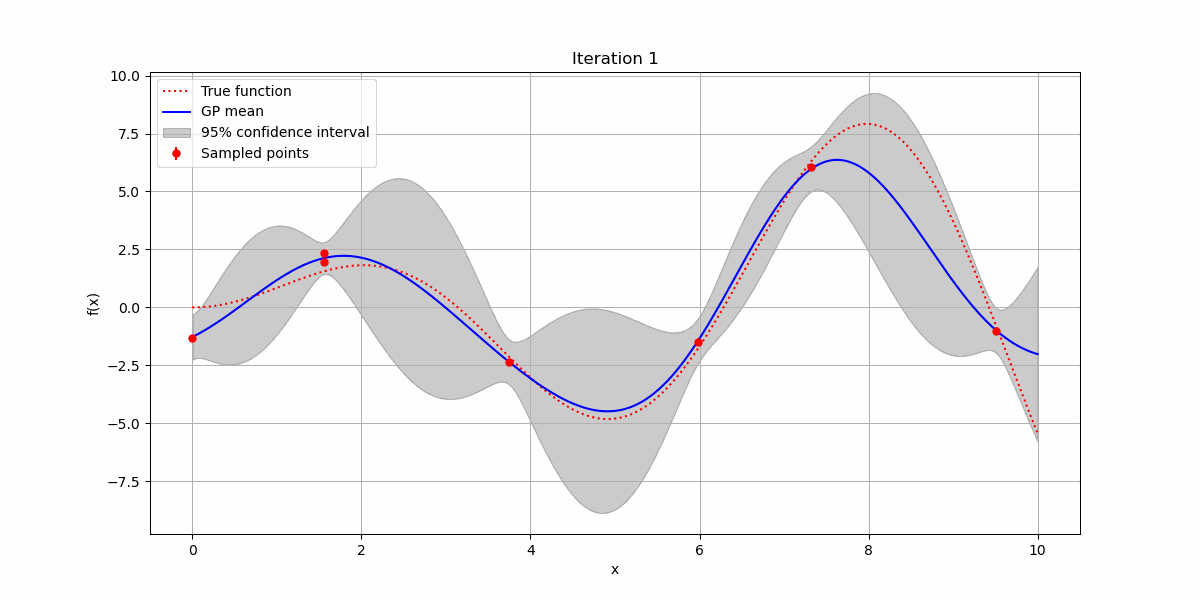

In [79]:
from IPython.display import Image

Image(filename='bayesian_optimization.gif')

## Effects of Different Hyperparameters
Visualize how different hyperparameters affect the GP predictions.


In [59]:
from ipywidgets import interact

def interactive_kernel(length_scale=1.3, variance=29.6, noise_variance=0.25):
    K = kernel(X_sample, X_sample, length_scale, variance) + noise_variance * np.eye(len(X_sample))
    K_inv = np.linalg.inv(K)
    Y_pred, sigma = gp_predict(X, X_sample, Y_sample, K, length_scale, variance)
    sigma = sigma.reshape(-1)

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(X, objective_function(X), 'r:', label='True function')
    ax1.errorbar(X_sample, Y_sample.ravel(), yerr=0, fmt='r.', markersize=10, label='Sampled points')
    ax1.plot(X, Y_pred, 'b-', label='GP mean')
    ax1.fill_between(X.ravel(), Y_pred.ravel() - 1.96 * sigma, Y_pred.ravel() + 1.96 * sigma, alpha=0.2, color='k', label='95% confidence interval')
    ax1.set_xlabel('x')
    ax1.set_ylabel('f(x)')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    plt.title('Gaussian Process Regression with Tuned Hyperparameters')
    plt.show()

interact(interactive_kernel, length_scale=(0.1, 5.0, 0.1), variance=(1, 50, 1), noise_variance=(0.01, 1.0, 0.01))



interactive(children=(FloatSlider(value=1.3, description='length_scale', max=5.0, min=0.1), IntSlider(value=29…

<function __main__.interactive_kernel(length_scale=1.3, variance=29.6, noise_variance=0.25)>

## Heatmap of the Acquisition Function
Visualize the acquisition function as a heatmap to get an intuitive understanding of its landscape.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


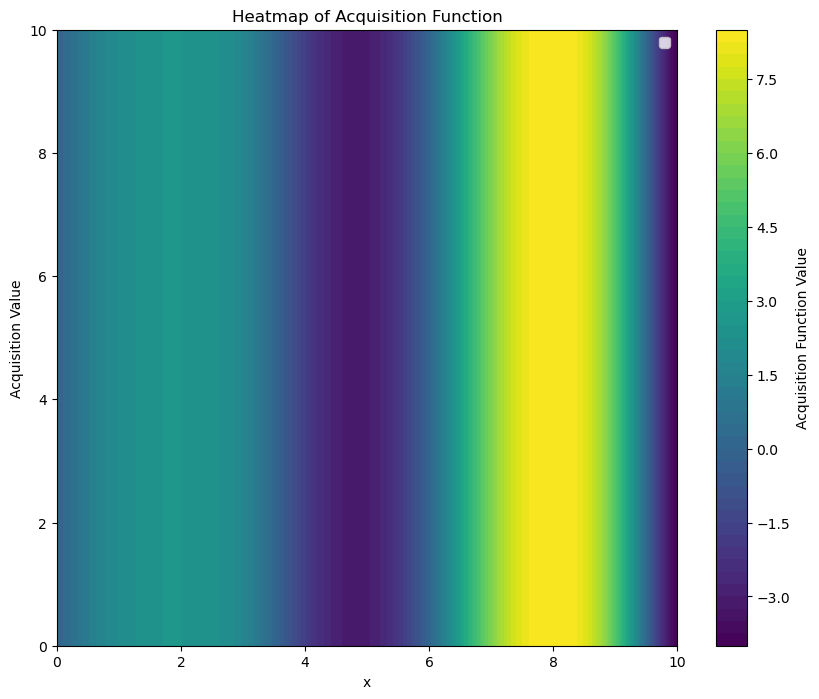

In [81]:
# Define the grid for the heatmap
x_grid = np.linspace(0, 10, 100).reshape(-1, 1)
X1, X2 = np.meshgrid(x_grid, x_grid)
acquisition_values = np.zeros(X1.shape)

# Compute the acquisition function values over the grid
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x_new = np.array([X1[i, j]])
        acquisition_values[i, j] = ucb(x_new, X_sample, Y_sample, K_inv, length_scale, variance)

# Plot the heatmap of the acquisition function
plt.figure(figsize=(10, 8))
contour = plt.contourf(X1, X2, acquisition_values, cmap='viridis', levels=50)
plt.colorbar(contour, label='Acquisition Function Value')
plt.title('Heatmap of Acquisition Function')
plt.xlabel('x')
plt.ylabel('Acquisition Value')
plt.legend()  
plt.show()